# Figures for point clouds

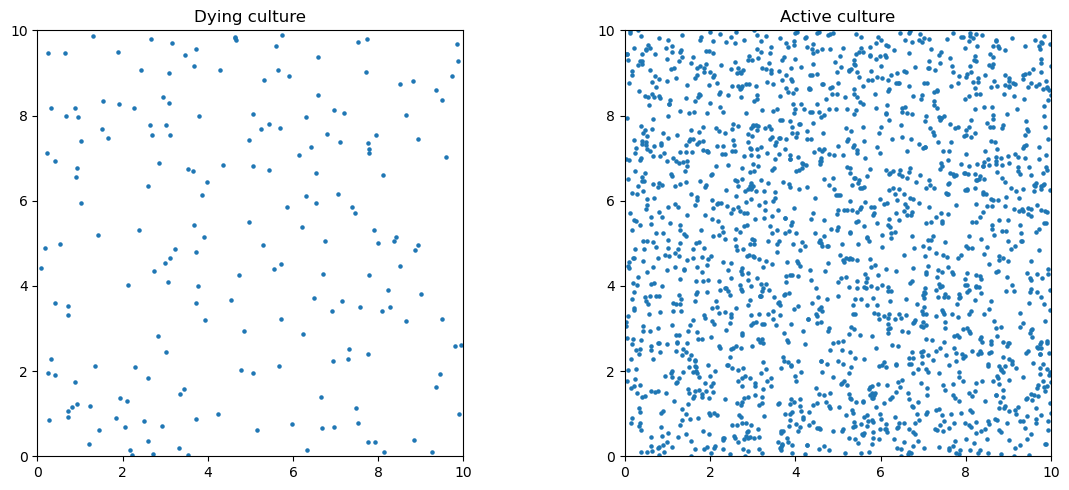

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def render_point_field(x,y,width=10,height=10,scale=10):
    Nx=int(width*scale)
    Ny=int(width*scale)
    
    img=np.zeros([Nx,Ny])
    
    for xx,yy in zip(x,y):
        img[int(xx*scale),int(yy*scale)]=1
        
    return img
        
def point_field(intensity=10,width=10,height=10,ax=None,title = None) :
    # Total expected number of points
    area = width * height
    num_points = np.random.poisson(intensity * area)

    # Generate uniform random points
    x = np.random.uniform(0, width, num_points)
    y = np.random.uniform(0, height, num_points)

    # Plot
    if ax is None:
        fig,ax=plt.subplots(1,figsize=(6, 6))
    
    ax.scatter(x, y, s=5)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    if title is None :
        ax.set_title(f"2D Poisson Point Field ({num_points} points)")
    else :
        ax.set_title(title)
        
    ax.set_aspect('equal')
    return x,y

    
fig,ax = plt.subplots(1,2,figsize=(12,5))  
dx,dy=point_field(intensity=2,ax=ax[0],title='Dying culture')
lx,ly=point_field(intensity=20,ax=ax[1], title='Active culture')
plt.tight_layout()
plt.savefig('figures/pointclouds.png',dpi=300)

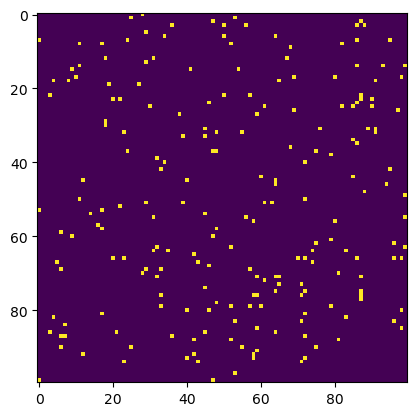

In [24]:
img = render_point_field(dx,dy,width=10,height=10,scale=10)
plt.imshow(img)

In [25]:
from scipy.spatial import Voronoi

In [54]:
from shapely.geometry import Polygon

def compute_region_areas(vor):
    areas = []
    for region_index in vor.point_region:
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            # Region is open (extends to infinity), skip or handle separately
            areas.append(np.nan)
            continue
        polygon = Polygon([vor.vertices[i] for i in region])
        areas.append(polygon.area)
    return np.array(areas)

In [56]:
A=compute_region_areas(vor)

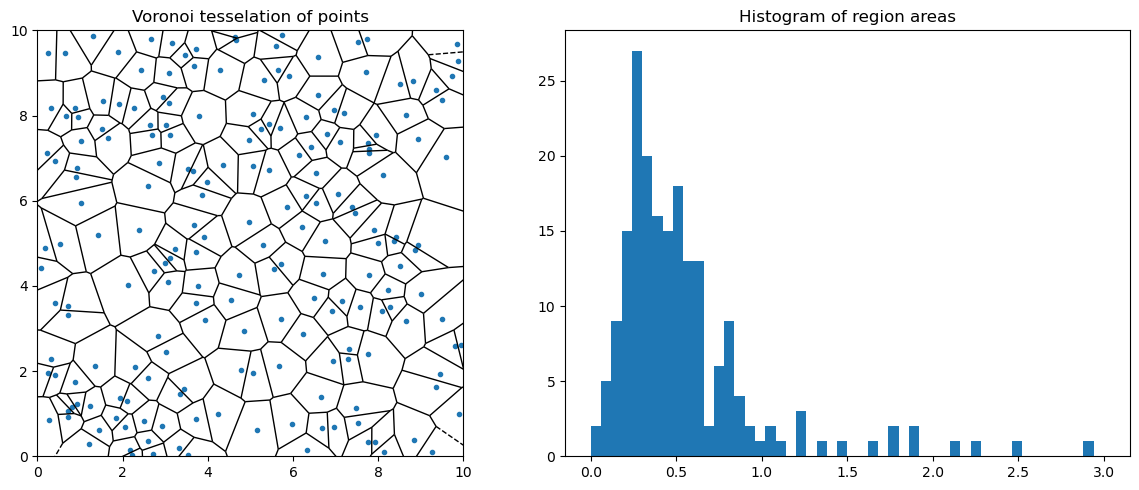

In [75]:
points = np.array([dx,dy]).transpose()

from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

fig,ax=plt.subplots(1,2,figsize=(12,5))
voronoi_plot_2d(vor,show_points=True, show_vertices=False,ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_xlim([0,10])
ax[0].set_ylim([0,10])
ax[0].set_title('Voronoi tesselation of points')

ax[1].hist(A,range=[0,3],bins=50);
ax[1].set_title('Histogram of region areas')
plt.tight_layout()
plt.savefig('figures/voronoi.png', dpi=300)

## Nearest neighbor

In [72]:
import numpy as np
from scipy.spatial import KDTree

# Example: random 2D or 3D points
# points = np.random.rand(100, 3)  # 3D point cloud with 100 points

# Build KD-tree
tree = KDTree(points)

# Query nearest neighbor (excluding the point itself)
# k=2 returns the point itself (distance 0) and its nearest neighbor
distances, indices = tree.query(points, k=2)

# Take the second column (nearest neighbor excluding self)
nearest_neighbor_distances = distances[:, 1]

# Optional: print average distance or plot histogram
print("Mean distance to nearest neighbor:", np.mean(nearest_neighbor_distances))

Mean distance to nearest neighbor: 0.37432830459415567


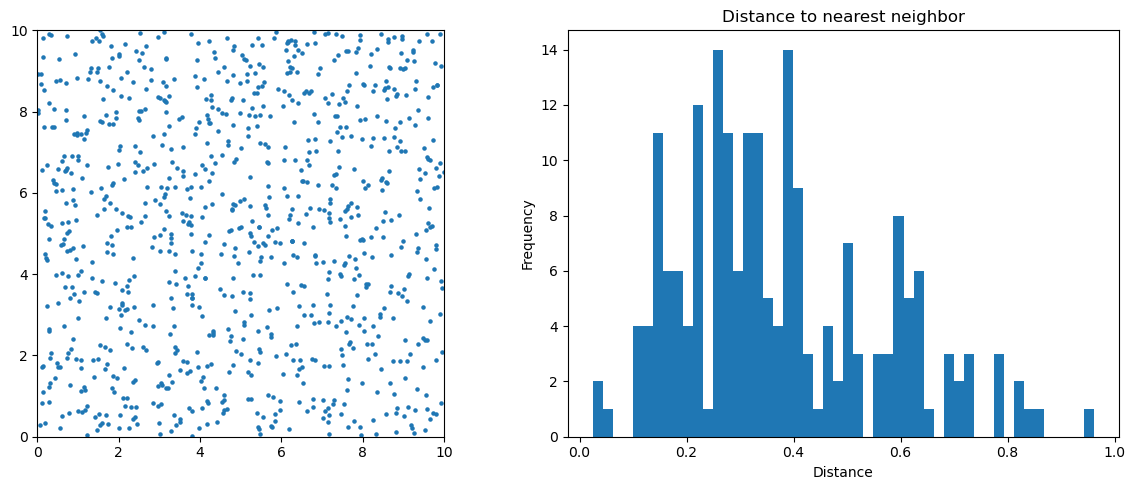

In [82]:
fig,ax = plt.subplots(1,2,figsize=[12,5])
ax[0].scatter(x, y, s=5)
ax[0].set_xlim(0, width)
ax[0].set_ylim(0, height)
ax[0].set_aspect('equal')
ax[1].hist(nearest_neighbor_distances,bins=50)
ax[1].set(title='Distance to nearest neighbor',xlabel='Distance',ylabel='Frequency')
plt.tight_layout()
plt.savefig('figures/nearest_neighbor.png', dpi=300)

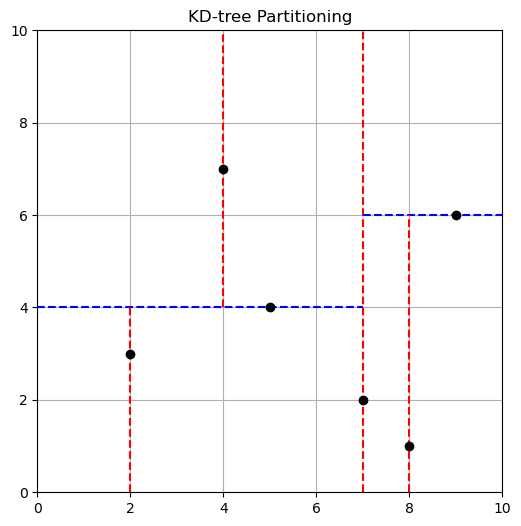

In [50]:
import numpy as np
import matplotlib.pyplot as plt

class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    if len(points) == 0:
        return None
    k = points.shape[1]
    axis = depth % k
    sorted_points = points[points[:, axis].argsort()]
    median_idx = len(sorted_points) // 2
    return KDNode(
        point=sorted_points[median_idx],
        axis=axis,
        left=build_kdtree(sorted_points[:median_idx], depth + 1),
        right=build_kdtree(sorted_points[median_idx + 1:], depth + 1)
    )

def draw_kdtree(node, bounds, depth=0):
    if node is None:
        return

    x_min, x_max, y_min, y_max = bounds
    x, y = node.point
    axis = node.axis

    if axis == 0:  # Vertical split (x-axis)
        plt.plot([x, x], [y_min, y_max], 'r--')
        left_bounds = (x_min, x, y_min, y_max)
        right_bounds = (x, x_max, y_min, y_max)
    else:  # Horizontal split (y-axis)
        plt.plot([x_min, x_max], [y, y], 'b--')
        left_bounds = (x_min, x_max, y_min, y)
        right_bounds = (x_min, x_max, y, y_max)

    draw_kdtree(node.left, left_bounds, depth + 1)
    draw_kdtree(node.right, right_bounds, depth + 1)

# Sample 2D points
points = np.array([
    [2, 3],
    [5, 4],
    [9, 6],
    [4, 7],
    [8, 1],
    [7, 2]
])

# Build tree and visualize
tree = build_kdtree(points)

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color='black', zorder=3)
draw_kdtree(tree, bounds=(0, 10, 0, 10))
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title("KD-tree Partitioning")
plt.grid(True)
plt.show()
